# Modeling and Error Analysis in Camera-Based Jump Height Measurement

This notebook was used to generate all results and figures for the research paper *"Modeling and Error Analysis in Camera-Based Jump Height Measurement"* submitted to the *Joint Annual Conference of the Austrian, German and Swiss Societies for Biomedical Engineering* (BMT2022).

First, set up the environment.

In [1]:
import cameratransform as ct
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy
import tikzplotlib
from IPython.display import display, Markdown
from cycler import cycler
import sys

mpl.use('Cairo') # Use Cairo backend to enable subpixel positioning for plot markers

# If Cairo is used, implicit figure showing and plt.show_close() does not work and produces a warning:
# "Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure."
# So we use the following function to explicitly show figures when needed. 
def plt_show_and_close_all_figures():
    while plt.get_fignums():
        display(plt.gcf())
        plt.close()
plt.show_close = plt_show_and_close_all_figures

def plt_save_show_close(filename, format='pgf', width_cm=8.2, height_cm=5, **kwargs):
    plt.gcf().set_size_inches(width_cm/2.54, height_cm/2.54)
    plt.savefig(filename, format=format, **kwargs)
    plt.show_close()
plt.save_show_close = plt_save_show_close

plt.style.use('seaborn-paper')

# Choose some colors which are dark enough for print and easily distinguishsable.
colors = ['xkcd:blue', 'xkcd:coral', 'xkcd:green', 'xkcd:olive', 'xkcd:aqua']
plt.rc('axes', prop_cycle=cycler(color=colors))

plt.rc('figure', dpi=100) # Increase figure display size in notebook

SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9

#plt.rc('font', family='serif')           # use document body font?
plt.rc('font', family='sans')            # figure captions use sans, so we use it for figures too
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Add some packages for the PGF backend for saving figures which contain \SI{}{} units in text.
plt.rc('pgf', preamble=r'\usepackage{amsmath}\usepackage{siunitx}')

## Camera setup

We create a camera object as described in https://cameratransform.readthedocs.io/en/latest/getting_started.html.

Camera parameters for the iPhone XR used in the original publication *"Measuring vertical jump height using a smartphone camera with simultaneous gravity-based calibration"* (2021) by Webering  et al. were determined from a photograph of a known object from a known distance.

In [2]:
gravity = 9.81

camera_height = 1.375 # meters above ground
default_subject_distance = 2.5 # default value in meters

# Normally, all numbers in variables are stored in meters.
# We can use this convenience function to convert them on demand for plotting, etc.
def scale(units, array):
    scale = units_scales[units]
    if scale == 1: return np.asarray(array)
    return np.asarray(array) * scale
units_scales = {
    'm': 1,
    'cm': 100,
    'mm': 1000,
    'in': 10000/254,
    'ft': 10000/3048,
    '%': 1 # Percent is just for plotting values which are already in percent but are passed through this function in a generic plotting helper function
}

def fov_from_photo(cam_distance_mm, object_size_mm, object_size_px, image_size_px):
    """Calculate the FoV from a photograph of an object of known size.
    
    Take a photograph from an object of known size (object_size_mm),
    for example a ruler, from a known distance (cam_distance_mm).
    The length axis of the known object must be aligned with the
    FoV direction you want to calculate.
    The object should fill almost the whole available length in the image,
    so if you want the horizontal FoV, it should fill almost the whole
    width of the image (object_size_px).
    Finally, image_size_px is the length of the image size along which you
    want to calculate the FoV (e.g. 1920 for the horizontal FoV in a FullHD image).
    """
    image_size_mm = object_size_mm / object_size_px * image_size_px
    return 2 * math.atan(image_size_mm / 2 / cam_distance_mm)

fov_deg = np.rad2deg(fov_from_photo(715, 850, 1940, 2000))
display(Markdown(f'FoV for iPhone XR camera from `Field of View iPhone XR.png` is: {fov_deg:.4f}°'))

# Some example intrinsic camera parameters. Copy-paste to create new camera definitions
cam_parameters_iphone_xr_slowmo = { # view_y_deg calculated using photo of a ruler
    'view_y_deg': 63,
    'sensor': (3.18, 5.66),
    'image': (1080, 1920),
}
# cam_parameters_iphone_xs_telephoto = { # Unverified configuration! Do not use without checking!
#     'focallength_mm': 6,
#     'sensor': (3.18, 5.66),
#     'image': (1080, 1920),
# }
# cam_parameters_iphone_xs_wideangle = { # Unverified configuration! Do not use without checking!
#     'focallength_mm': 4.25,
#     'sensor': (4.2, 5.6),
#     'image': (1080, 1920),
# }

#########################################################################
#### Set this variable in order to change which camera is used by default
selected_camera = cam_parameters_iphone_xr_slowmo
#selected_camera = cam_parameters_iphone_xs_telephoto
#selected_camera = cam_parameters_iphone_xs_wideangle
#########################################################################


# Create a default camera object, allowing the user to override specific parameters.
def create_camera(*cam_args, cam_angle=0, distance=default_subject_distance, **orientation_kwargs):
    return ct.Camera(
        ct.RectilinearProjection(**selected_camera),
        ct.SpatialOrientation(
            elevation_m=camera_height, # z height above floor
            tilt_deg=90 + cam_angle, # 90 degrees == look in +Y direction, 0 degrees == look straight down
            pos_y_m=-distance, # subject is at (0,0,0), camera is at (0,-d,0)
            **orientation_kwargs
        ),
        *cam_args
    )

cam = create_camera()
print(cam.projection)
print('fov =', cam.projection.getFieldOfView())

image_w, image_h = selected_camera['image']

FoV for iPhone XR camera from `Field of View iPhone XR.png` is: 62.9990°

  intrinsic (RectilinearProjection):
    f:		1566.6 px
    sensor:	3.18×5.66 mm
    image:	1080×1920 px

fov = (38.038190364078396, 63.0)


### Recreate FoV calculation scene

For determining the FoV of the camera, we took a photograph of a 0.866 m long ruler from a distance of 0.715 m.
In this figure we recreate the scene in order to check if our calculated FoV value is reasonable.

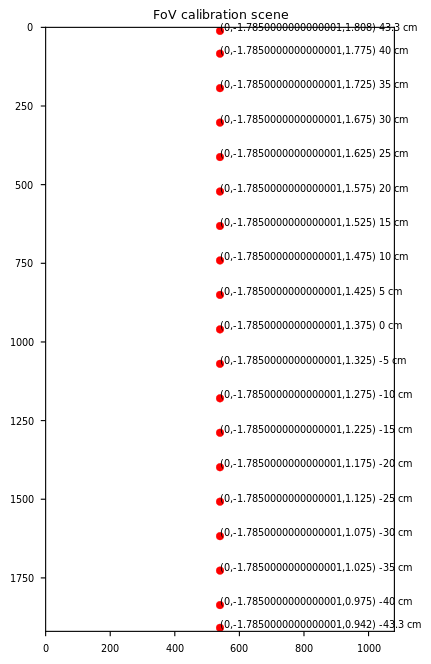

In [3]:
def plot_mark_point(x, y, z, text=''):
    point_2d = cam.imageFromSpace((x,y,z))
    plt.scatter(*point_2d, color='red')
    plt.gca().annotate(f'({x},{y},{z}) {text}', point_2d)

plt.figure(figsize=(4.5,8))
plt.ylim(0, image_h)
plt.xlim(0, image_w)
plt.gca().invert_yaxis()
plt.title('FoV calibration scene')
for cm in range(-50, 51, 5):
    plot_mark_point(0, -default_subject_distance + 0.715, camera_height + cm/100, f'{cm} cm')
plot_mark_point(0, -default_subject_distance + 0.715, camera_height + 43.3/100, f'{43.3} cm')
plot_mark_point(0, -default_subject_distance + 0.715, camera_height - 43.3/100, f'{-43.3} cm')
plt.show_close()



### Test camera projection

In order to verify that the camera model is set up correctly, we create some points in the XY plane, at Z=0.

Then we can use the camera model to transform the 3D coordinates into the image coordinate system. The head and feet of a 1.80 meters tall person standing at the origin `(0,0,0)` are marked in the image, in order to verify that the projection looks realistic and everything is visible to the camera.

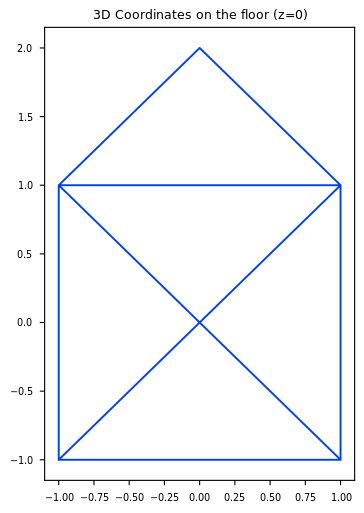

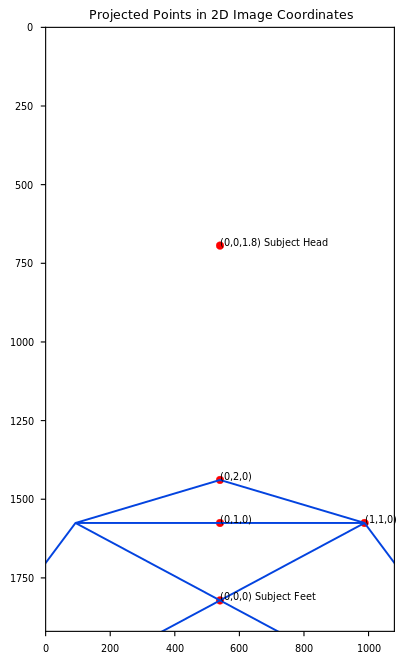

In [4]:
# Points in meters in x,y,z format.
house_points_3d = np.array([
          [-1, -1, 0],
          [ 1, -1, 0],
          [-1,  1, 0],
          [ 1,  1, 0],
          [ 0,  2, 0],
          [-1,  1, 0],
          [-1, -1, 0],
          [ 1,  1, 0],
          [ 1, -1, 0],
])

plt.figure(figsize=(4,6))
plt.title('3D Coordinates on the floor (z=0)')
plt.plot(house_points_3d[:,0], house_points_3d[:,1])
plt.show_close()

cam = cam = create_camera(cam_angle=0)

points_2d = cam.imageFromSpace(house_points_3d) # Perspective transformation

plt.figure(figsize=(4.5,8))
plt.ylim(0, image_h)
plt.xlim(0, image_w)
plt.gca().invert_yaxis()
plt.title('Projected Points in 2D Image Coordinates')
plt.plot(points_2d[:,0], points_2d[:,1])
plot_mark_point(0,0,0, 'Subject Feet')
plot_mark_point(0,1,0)
plot_mark_point(1,1,0)
plot_mark_point(0,2,0)
plot_mark_point(0,0,1.8, 'Subject Head')
plt.show_close()


## Functions to create free-fall parabolas

`create_jump` creates a parabola in world coordinates (meters and seconds)

`create_jump_camera` creates a parabola as seen through a camera, including errors like misalignment or varying subject distance

`map_jump_camera` takes a jump in world coordinates, projects it into image coordinates, and applied variious configurable disturbances.

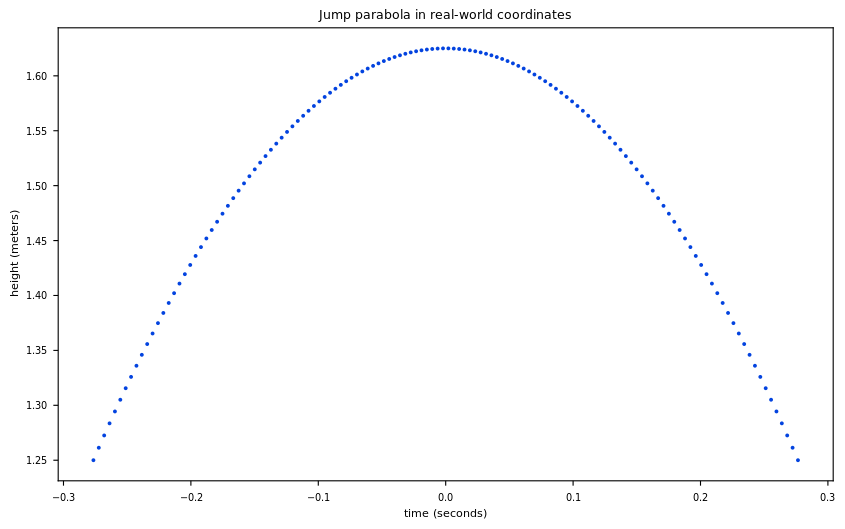

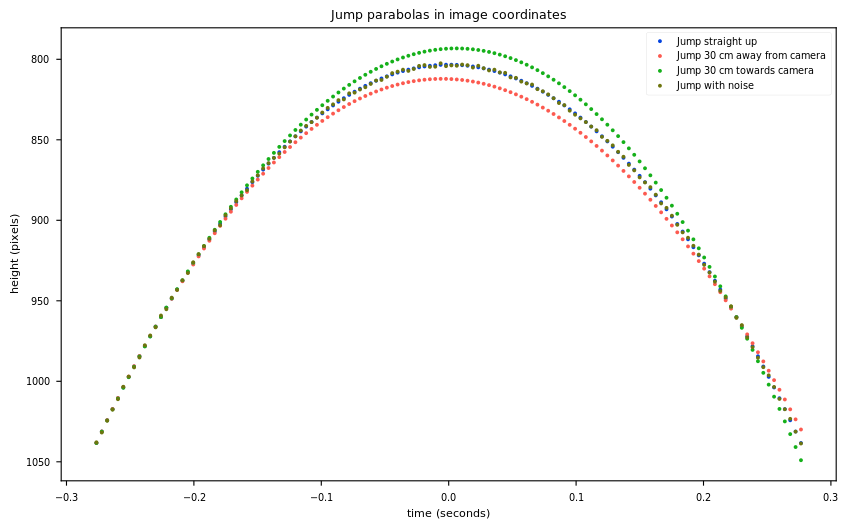

In [5]:
import math

def create_jump(stand_height, jump_height, fps=240):
    duration = np.sqrt(jump_height * 8 / gravity)
    t = np.linspace(-duration/2, duration/2, int(fps * duration))
    v_0 = 0
    z_0 = stand_height + jump_height
    z = -gravity/2 * t**2 + v_0*t + z_0
    return t, z

def map_jump_camera(t, z, cam_angle=0, distance=default_subject_distance,
                    noise=None, noise_args={}, distance_movement=0,
                    rounded=False, distortion=None, fps=240):
    if distortion is not None:
        cam = create_camera(ct.BrownLensDistortion(k1=distortion, k2=distortion, k3=distortion))
    else:
        cam = create_camera()
    cam.pos_y_m = -distance
    cam.tilt_deg = 90 - cam_angle
    x = np.zeros(len(z))
    y = np.linspace(0, distance_movement, len(z))
    array = np.array([x, y, z]).transpose()
    y_img = cam.imageFromSpace(array)[:,1]
    if noise is not None:
        if callable(noise):
            noise = noise(t, **noise_args)
        y_img += noise
    if rounded:
        y_img = y_img.round()
    return t, y_img

def create_jump_camera(stand_height, jump_height, fps=240, **kwargs):
    t, z = create_jump(stand_height, jump_height, fps=fps)
    return map_jump_camera(t, z, **kwargs)

test_stand_height = 1.25
test_jump_height = 0.375
t, z = create_jump(test_stand_height, test_jump_height)

# Some sanity checks to make sure that the parabola is as expected
assert z[0] == test_stand_height
assert z[-1] == test_stand_height
assert z[len(z) // 2] - (test_stand_height + test_jump_height) < 0.00001
assert len(z) == 132

plt.figure(figsize=(10,6))
plt.title('Jump parabola in real-world coordinates')
plt.xlabel('time (seconds)')
plt.ylabel('height (meters)')
plt.plot(t, z, marker='.', lw=0)
plt.show_close()

t_img, y_img = create_jump_camera(test_stand_height, test_jump_height)
t_img2, y_img2 = create_jump_camera(test_stand_height, test_jump_height, distance_movement=0.3)
t_img3, y_img3 = create_jump_camera(test_stand_height, test_jump_height, distance_movement=-0.3)
t_img4, y_img4 = create_jump_camera(test_stand_height, test_jump_height, noise=lambda t: 2*np.random.rand(len(t))-1)
plt.figure(figsize=(10,6))
plt.title('Jump parabolas in image coordinates')
plt.xlabel('time (seconds)')
plt.ylabel('height (pixels)')
plt.gca().invert_yaxis()
plt.plot(t_img,  y_img, marker='.', lw=0, label="Jump straight up")
plt.plot(t_img2, y_img2, marker='.', lw=0, label="Jump 30 cm away from camera")
plt.plot(t_img3, y_img3, marker='.', lw=0, label="Jump 30 cm towards camera")
plt.plot(t_img4, y_img4, marker='.', lw=0, label="Jump with noise")
plt.legend()
plt.show_close()


## Functions to calculate jump height from parabola

Define function `calcjumpheight` to calculate jump height from a set of parabola coefficients and a standing height.

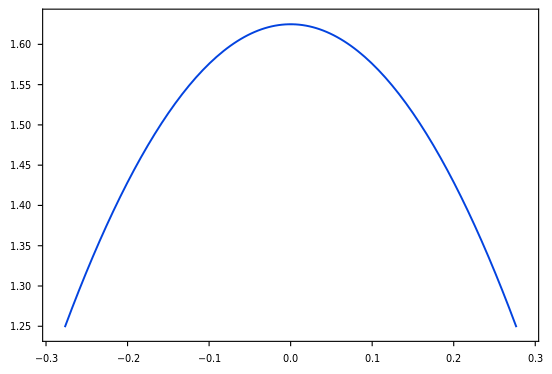

3D: a, b, c = [-4.90500000e+00 -4.82723325e-09  1.62500000e+00]


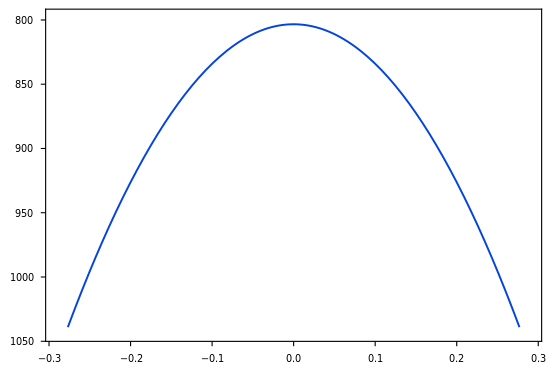

2D: a, b, c = [3.07362529e+03 5.34867722e-06 8.03342238e+02]
Jump Height error from 3D parabola:  5.0897508430125527e-11
Jump Height error from 2D parabola:  -2.8054558676160468e-11
eval_jump:  -5.551115123125783e-17


In [6]:
from scipy.optimize import curve_fit

def parabolic(x, a, b,c):
    return (a*x + b) * x + c

def calcjumpheight(standing_height, parabola_coefficients, calibrate_units=True):
    '''Calculate the jump height in meters from a fitted parabola.
    
    standing_height: in meters or pixels
    parabola_coefficients: in meters or pixels
    calibrate_units (default True):
        If True: calculate the scale of the parabola from the free-fall acceleration.
        Should be True when working with traces from videos in pixel coordinates.
        If False: return the different between standing_height and the highest point without unit conversion.
        Should only be set to False if you know that the input units are in meters
        and know the system to be accurate, for example a motion capture system.
        Leaving it as True in that case will still work, but will try to calibrate the unit scaling
        of your motion capture system from the shape of the parabola, which may or may not
        be more accurate than the motion capture system itself.
    '''
    a, b, c = parabola_coefficients
    highest_point = c - b * b / (4 * a)
    if calibrate_units:
        height=(highest_point - standing_height) * -gravity / (2*a)
    else:
        height=(highest_point - standing_height)
    return height

def parabola_initial_guess(t, z):
    '''Adapted and modifed to get the unknowns for defining a parabola:
    http://stackoverflow.com/questions/717762/how-to-calculate-the-vertex-of-a-parabola-given-three-points
    '''
    #return None # Uncomment this for speed comparison
    mid = len(z)//2
    x1, y1 = t[0], z[0]
    x2, y2 = t[-1], z[-1]
    x3, y3 = t[mid], z[mid]
    denom = (x1-x2) * (x1-x3) * (x2-x3)
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom
    return A, B, C

def fit_parabola(t, z):
    # Starting with a good guess instead of [1,1,1] makes curve fitting ca. 30% faster
    coeff0 = parabola_initial_guess(t,z)
    # Don't use curve_fit because it often complains that it can't estimate covariance parameters
    #coefficients, pcov = curve_fit(parabolic, t, z, p0=coeff0)
    residual = lambda x: parabolic(t, *x) - z
    coefficients, *_ = scipy.optimize.leastsq(residual, coeff0)
    return coefficients

def jump_height_from_parabola(t, z, standing_height=None, calibrate_units=True, max_error=100):
    if standing_height is None:
        standing_height = z[0]
    coefficients = fit_parabola(t, z)
    rms = np.sqrt(np.mean(np.square(z - parabolic(t, *coefficients))))
    if rms > max_error: # RMS Error > 100 pixel? Something is very wrong.
        print(f'FITTING ERROR {rms:.2f}px > {max_error}px!', file=sys.stderr)
        plt.figure(figsize=(10,10))
        plt.title(f'FITTING ERROR {rms}px > {max_error}px!')
        plt.plot(t, z, label='samples')
        plt.plot(t, parabolic(t, *coefficients), label='fit')
        plt.legend()
        plt.show_close()
        print(f'coefficients={coefficients}, rms={rms}')
        raise ValueError(f'RMS Curve Fitting Error > {max_error} px')
    return calcjumpheight(standing_height, coefficients, calibrate_units=calibrate_units)

def eval_jump(t, z, standing_height=None, max_error=100, **kwargs):
    t_img, y_img = map_jump_camera(t, z, **kwargs)
    return jump_height_from_parabola(t_img, y_img, standing_height=standing_height, max_error=max_error)

# Curve fit on world coordinate data
t, z = create_jump(test_stand_height, test_jump_height)
coefficients, _pcov = curve_fit(parabolic, t, z)  #curve_fit(objective, x_values, y_values)
plt.plot(t,z)
plt.show_close()
print('3D: a, b, c =', coefficients)

# Curve fit on image coordinate data
t_img, y_img = create_jump_camera(test_stand_height, test_jump_height)
coefficients_2d, _pcov_2d = curve_fit(parabolic, t_img, y_img)
plt.plot(t_img,y_img)
plt.gca().invert_yaxis()
plt.show_close()
print('2D: a, b, c =', coefficients_2d)


print("Jump Height error from 3D parabola: ", calcjumpheight(z[0], coefficients, False) - test_jump_height)
print("Jump Height error from 2D parabola: ", calcjumpheight(y_img[0], coefficients_2d, True) - test_jump_height)
print("eval_jump: ", eval_jump(t, z, rounded=False) - test_jump_height)


## Test a single jump with different camera angles



angle=-20, Jump Height from 2D parabola: 0.3795, Error:, +0.45 cm
angle=-10, Jump Height from 2D parabola: 0.3772, Error:, +0.22 cm
angle= +0, Jump Height from 2D parabola: 0.3750, Error:, -0.00 cm
angle=+10, Jump Height from 2D parabola: 0.3728, Error:, -0.22 cm
angle=+20, Jump Height from 2D parabola: 0.3706, Error:, -0.44 cm


/home/webering/.virtualenvs/jupyter/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


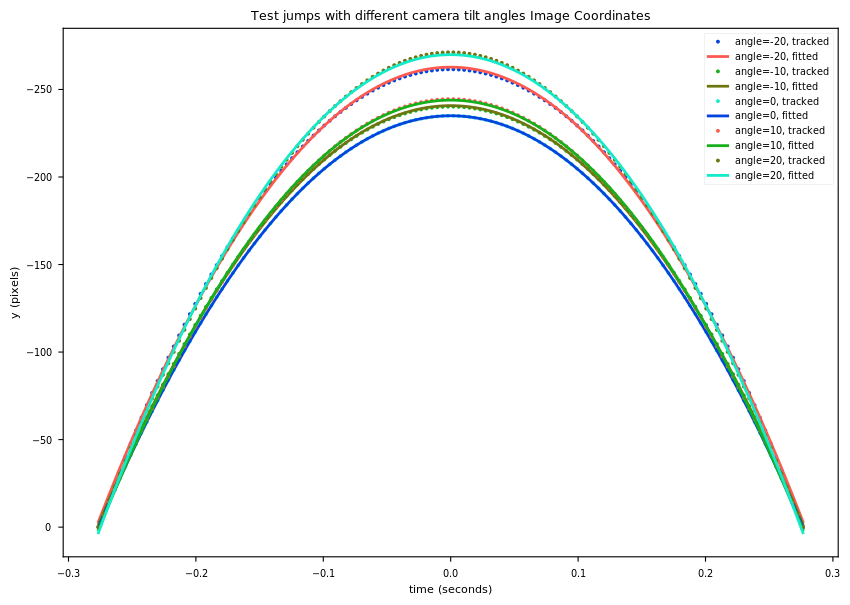

In [7]:
plt.figure(figsize=(10,7))
plt.gca().invert_yaxis()
plt.title('Test jumps with different camera tilt angles Image Coordinates')
plt.xlabel('time (seconds)')
plt.ylabel('y (pixels)')

for angle in range(-20, 21, 10):
    t, y = create_jump_camera(test_stand_height, test_jump_height, cam_angle=angle)
    params_2d, pcov_2d = curve_fit(parabolic, t, y)
    height = jump_height_from_parabola(t, y)

    print(f'angle={angle:+3.0f}, Jump Height from 2D parabola: {height:.4f}, Error:, {scale("cm", (height - test_jump_height)):+.2f} cm')

    plt.plot(t, y - y[0] , lw=0, marker='.', label=f'angle={angle}, tracked')
    plt.plot(t, parabolic(t, *params_2d) - y[0], lw=2, label=f'angle={angle}, fitted')

plt.legend()
plt.show_close()


# Create dataset with different jumps

Creates jumps with random standing height and random jump height. A seed will be used to generate the same jumps each time.

The dataset consists of one half male subjects and one half female subjects. Even-numbered indices are male and odd-numbered indices are female. Thus, the dataset can be cut into smaller parts while still retaining the ratio of male to female subjects.

## First, generate some subjects with different body heights

Body heights are normally distributed, mean and standard deviation are taken from https://ourworldindata.org/human-height#height-is-normally-distributed.
Center of mass is arbitrarily placed at 65% of body height.


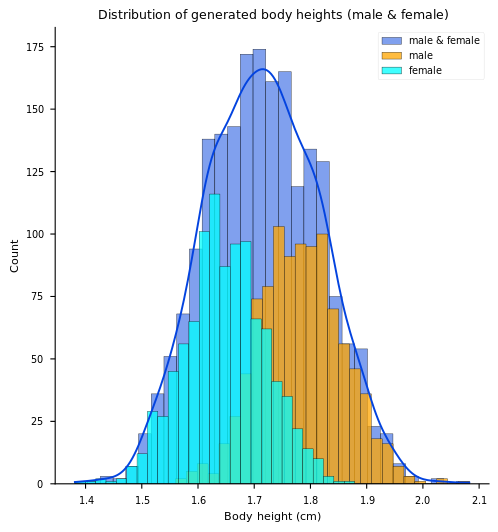

In [8]:
seed=12345
dataset_size = 2000
assert dataset_size % 2 == 0, 'Need even sized dataset to have equal number of men and women'
standing_height_location = 0.65

male_height_mean, male_height_sd = 1.784, 0.076
female_height_mean, female_height_sd = 1.647, 0.071

def interleave_arrays(a, b):
    a, b = np.asarray(a), np.asarray(b)
    result = np.empty((a.size + b.size,), dtype=a.dtype)
    result[0::2] = a
    result[1::2] = b
    return result

np.random.seed(seed)
body_heights_male = np.random.normal(loc=male_height_mean, scale=male_height_sd, size=dataset_size//2)
body_heights_female = np.random.normal(loc=female_height_mean, scale=female_height_sd, size=dataset_size//2)
dataset_body_heights = interleave_arrays(body_heights_male, body_heights_female)
dataset_standing_heights = dataset_body_heights * standing_height_location

sns.displot(dataset_body_heights, kde=True, label='male & female')
sns.histplot(body_heights_male, color='orange', label='male')
sns.histplot(body_heights_female, color='cyan', label='female')
sns.despine()
plt.legend()
plt.title('Distribution of generated body heights (male & female)')
plt.xlabel('Body height (cm)')
plt.show_close()




## Generate a jump height for each subject in the dataset

Distribution of jump heighs of squat jumps for male subjects are taken from https://www.researchgate.net/profile/Ramon-Centeno-Prada/publication/278039701_Jump_percentile_A_proposal_for_evaluation_of_high_level_sportsmen/links/5639459508ae4624b75efec1/Jump-percentile-A-proposal-for-evaluation-of-high-level-sportsmen.pdf
Jump heights for percentiles 0 and 100 were added manually in order to obtain a workable distribution without extreme outliers.

Female jump heights are not given in the paper, so we just scale down male jump heights by the ratio of mean body heights between males and females.



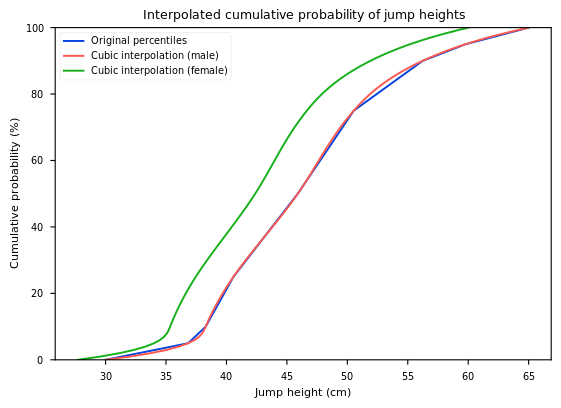

2000


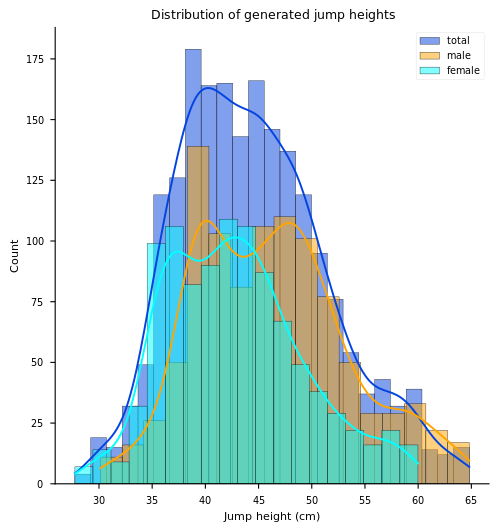

In [9]:
jump_percentiles = np.array([0, 5, 10, 25, 50, 75, 90, 95, 100])
jump_percentile_heights_male = 0.01 * np.array([30.0, 36.84, 38.28, 40.58, 45.90, 50.53, 56.23, 59.78, 65.0])
jump_percentile_heights_female = jump_percentile_heights_male / male_height_mean * female_height_mean
interpolate_male = scipy.interpolate.interp1d(jump_percentiles, jump_percentile_heights_male, kind='cubic')
interpolate_female = scipy.interpolate.interp1d(jump_percentiles, jump_percentile_heights_female, kind='cubic')

all_percentiles = np.linspace(0, 100, num=101, endpoint=True)
plt.title('Interpolated cumulative probability of jump heights')
plt.xlabel('Jump height (cm)')
plt.ylabel('Cumulative probability (%)')
plt.plot(jump_percentile_heights_male*100, jump_percentiles, label='Original percentiles')
plt.plot(interpolate_male(all_percentiles)*100, all_percentiles, label='Cubic interpolation (male)')
plt.plot(interpolate_female(all_percentiles)*100, all_percentiles, label='Cubic interpolation (female)')
plt.legend()
plt.ylim(min(jump_percentiles), max(jump_percentiles))
plt.show_close()

np.random.seed(seed+1) # Use a different seed than for the body heights
dataset_jump_heights_male = interpolate_male(np.random.rand(dataset_size // 2) * 100)
dataset_jump_heights_female = interpolate_female(np.random.rand(dataset_size // 2) * 100)
dataset_jump_heights = interleave_arrays(dataset_jump_heights_male, dataset_jump_heights_female)
print(len(dataset_jump_heights))

sns.displot(dataset_jump_heights*100, kde=True, label='total')
sns.histplot(dataset_jump_heights_male*100, color='orange', label='male', kde=True)
sns.histplot(dataset_jump_heights_female*100, color='cyan', label='female', kde=True)
sns.despine()
plt.title('Distribution of generated jump heights')
plt.xlabel('Jump height (cm)')
plt.legend()
plt.show_close()


## Generate jump parabolas from standing heights and jump heights

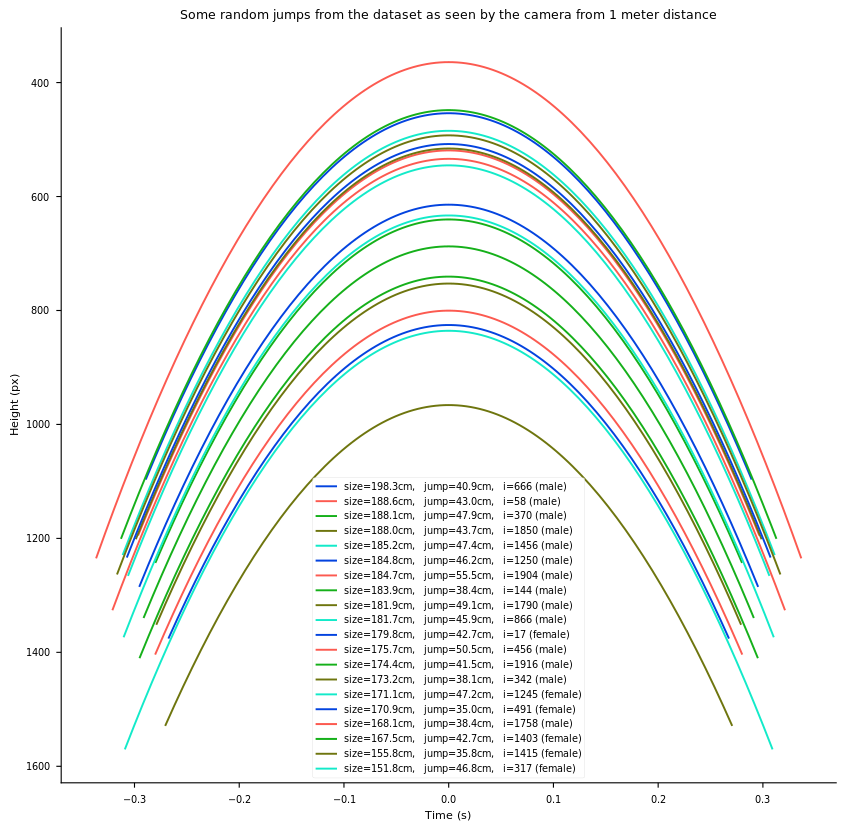

0.5812732353040236
0.5812732353040235
0.40916274625896865
0.40916274625896876


In [10]:
dataset = [
    create_jump(dataset_standing_heights[i], dataset_jump_heights[i])
        for i in range(dataset_size)
]

plt.figure(figsize=(10,10))
plt.gca().invert_yaxis()
np.random.seed(seed + 5)
for i in sorted(np.random.randint(dataset_size, size=20), key=lambda i: -dataset_body_heights[i]):
    t_img, y_img = map_jump_camera(*dataset[i], distance=1)
    plt.plot(t_img, y_img, label=f'size={dataset_body_heights[i]*100:.1f}cm,   jump={dataset_jump_heights[i]*100:.1f}cm,   i={i} ({("fe" if i%2==1 else "") + "male"})')
plt.title('Some random jumps from the dataset as seen by the camera from 1 meter distance')
plt.xlabel('Time (s)')
plt.ylabel('Height (px)')
plt.legend()
sns.despine()
plt.show_close()

print(eval_jump(dataset[0][0], dataset[0][1]))
print(dataset_jump_heights[0])
print(eval_jump(dataset[1][0], dataset[1][1]))
print(dataset_jump_heights[1])

## Check estimation accuracy with only rounding to whole pixels

In [11]:
heights_reconstructed_2d = np.asarray([
    eval_jump(t, z, rounded=True) for t, z in dataset
])

Mean Estimation Error (mm): 0.0026880129870629488
Standard Deviation of Estimation Error (mm): 0.4360779625284257


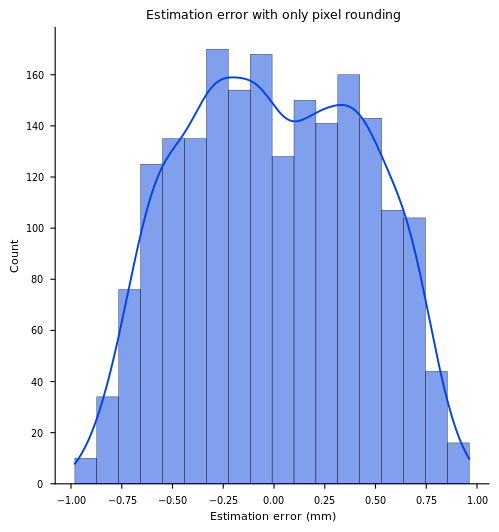

In [12]:
heights_reconstructed_2d_errors = heights_reconstructed_2d - dataset_jump_heights
print(f'Mean Estimation Error (mm): {1000 * np.mean(heights_reconstructed_2d_errors)}')
print(f'Standard Deviation of Estimation Error (mm): {1000 * np.std(heights_reconstructed_2d_errors)}')
sns.displot(1000 * heights_reconstructed_2d_errors, kde=True)
plt.title('Estimation error with only pixel rounding')
plt.xlabel('Estimation error (mm)')
plt.show_close()

## Estimation error over camera distance

Vary the distance between subject and camera from 1 to 20 meters and reconstruct jump height.
The only estimation difficulty here is rounding to pixels.

In [13]:
table_column_values = np.asarray([-8, -4, -2, -1, 0, 1, 2, 4, 8])
all_parameter_values = np.asarray(range(-10, 11))

# min_distance = 1.0
# max_distance = 20.0
# distances = np.linspace(min_distance, max_distance, )
distances = all_parameter_values[all_parameter_values > 0]
heights_dist = np.asarray([
    [eval_jump(t, z, distance=d, rounded=True) for t, z in dataset]
    for d in distances
])


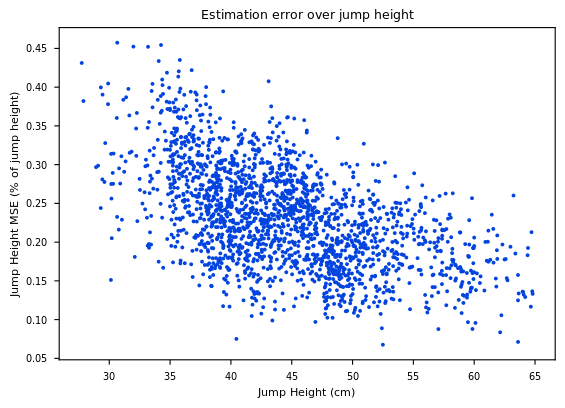

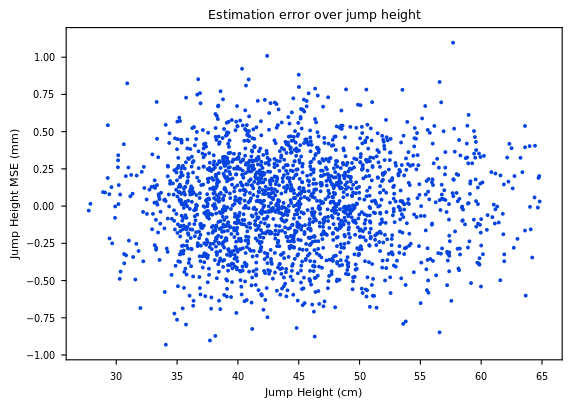

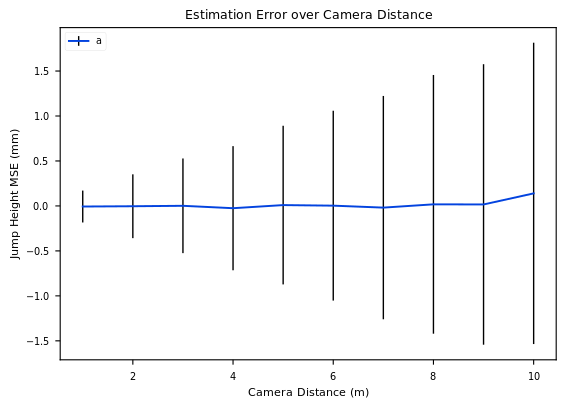

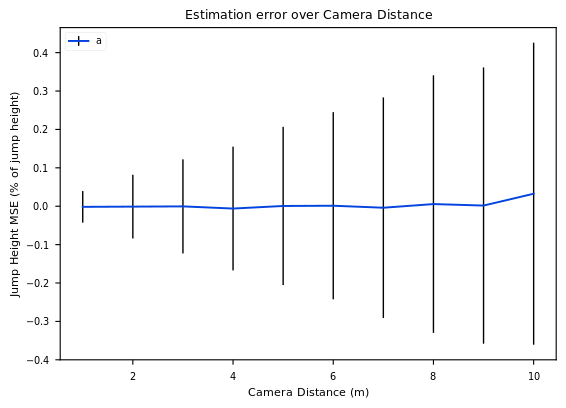

In [14]:
heights_dist_errors = (heights_dist - dataset_jump_heights)
heights_dist_mean_jump = np.mean(heights_dist, axis=0)
heights_dist_percent_std_jump = 100 * np.std(heights_dist_errors / dataset_jump_heights, axis=0)
heights_dist_mean = np.mean(heights_dist_errors, axis=1)
heights_dist_mean_jump = np.mean(heights_dist_errors, axis=0)
heights_dist_std = np.std(heights_dist_errors, axis=1)
heights_dist_percent_mean = 100 * np.mean(heights_dist_errors / dataset_jump_heights, axis=1)
heights_dist_percent_std = 100 * np.std(heights_dist_errors / dataset_jump_heights, axis=1)


plt.plot(scale('cm', dataset_jump_heights), heights_dist_percent_std_jump, lw=0, marker='.')
plt.title('Estimation error over jump height')
plt.xlabel('Jump Height (cm)')
plt.ylabel('Jump Height MSE (% of jump height)')
plt.show_close()

plt.plot(scale('cm', dataset_jump_heights), scale('mm', heights_dist_mean_jump), lw=0, marker='.')
plt.title('Estimation error over jump height')
plt.xlabel('Jump Height (cm)')
plt.ylabel('Jump Height MSE (mm)')
plt.show_close()

plt.errorbar(distances, scale('mm', heights_dist_mean), yerr=scale('mm', heights_dist_std), ecolor='black', elinewidth = 1, capsize=3, label='a')
plt.title('Estimation Error over Camera Distance')
plt.xlabel('Camera Distance (m)')
plt.ylabel('Jump Height MSE (mm)')
plt.legend()
plt.show_close()

plt.errorbar(distances, heights_dist_percent_mean, yerr=heights_dist_percent_std, ecolor='black', elinewidth = 1, capsize=3, label='a')
plt.title('Estimation error over Camera Distance')
plt.xlabel('Camera Distance (m)')
plt.ylabel('Jump Height MSE (% of jump height)')
plt.legend()
plt.show_close()

## Estimation error over camera distance with noise

Vary the distance between subject and camera from 1 to 20 meters and reconstruct jump height.
Additionally, noise is added to simulate feature detection inaccuracy.

First, let's define and test a fractal noise function which will be used to add multiple frequencies of noise to the 2d trajectories before jump height estimation.

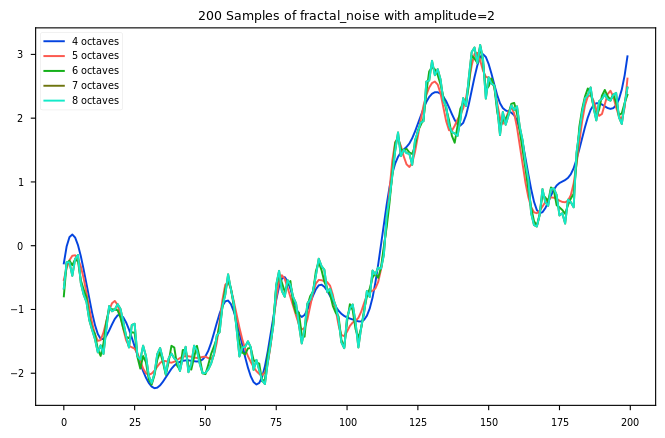

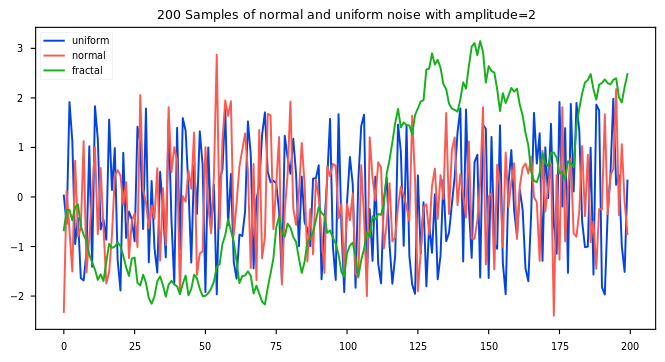

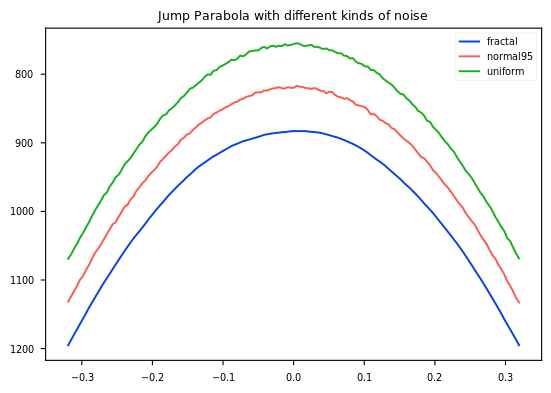

In [15]:
default_noise_amplitude=2

def fractal_noise(ref, amplitude=default_noise_amplitude, amplitude_factor=1.5, octaves=7):
    """Returns fractal value noise, lowest frequency aligned to the total length of the sequence.
    
    ref: Either the number of values to generate, or a sequence which is as long as the number of values to generate.
    amplitude: The amplitude of the lowest octave (the total amplitude of the resulting noise is likely larger than this)
    amplitude_factor: Ratio between amplitudes of successive octaves.
    octaves: Number of octaves to add up.
        The lowest octave has 4 noise samples, each octave above has twice as much as the one below.
    """
    try:
        count = int(ref)
    except:
        count = len(ref)
    x = np.linspace(0, 1, count)
    total = np.zeros(count)
    for octave in range(octaves):
        ampl = amplitude / amplitude_factor ** octave
        count_oct = 4 * 2 ** octave
        x_oct = np.linspace(0, 1, count_oct)
        noise = ampl * 2 * (np.random.rand(count_oct) - 0.5)
        interpolate = scipy.interpolate.interp1d(x_oct, noise, kind='cubic')
        total += interpolate(x)
        if count_oct >= count:
            break # Stop after we hit max resolution
    #print(octaves, ampl)
    return total

def uniform_noise(ref, amplitude=default_noise_amplitude):
    """Returns uniform value noise.
    
    ref: Either the number of values to generate, or a sequence which is as long as the number of values to generate.
    amplitude: The amplitude of the noise signal (from mean, not peak-to-peak).
    """
    try:
        count = int(ref)
    except:
        count = len(ref)
    return 2 * amplitude * (np.random.rand(count) - 0.5)

def normal95_noise(ref, amplitude=default_noise_amplitude):
    """Returns normally distributed value noise with 95% of values within `amplitude` of 0.
    
    ref: Either the number of values to generate, or a sequence which is as long as the number of values to generate.
    amplitude: The amplitude of the noise signal (from mean, not peak-to-peak).
    """
    try:
        count = int(ref)
    except:
        count = len(ref)
    return np.random.normal(size=count, loc=0, scale=amplitude/1.96)

plt.figure(figsize=(8,5))
plt.title('200 Samples of fractal_noise with amplitude=2')
np.random.seed(seed+10)
plt.plot(fractal_noise(200, amplitude=2, octaves=4), label='4 octaves')
np.random.seed(seed+10)
plt.plot(fractal_noise(200, amplitude=2, octaves=5), label='5 octaves')
np.random.seed(seed+10)
plt.plot(fractal_noise(200, amplitude=2, octaves=6), label='6 octaves')
np.random.seed(seed+10)
plt.plot(fractal_noise(200, amplitude=2, octaves=7), label='7 octaves')
np.random.seed(seed+10)
plt.plot(fractal_noise(200, amplitude=2, octaves=8), label='8 octaves')
plt.legend()
plt.show_close()

plt.figure(figsize=(8,4))
plt.title('200 Samples of normal and uniform noise with amplitude=2')
np.random.seed(seed+10)
plt.plot(uniform_noise(200, amplitude=2), label='uniform')
np.random.seed(seed+10)
plt.plot(normal95_noise(200, amplitude=2), label='normal')
np.random.seed(seed+10)
plt.plot(fractal_noise(200, amplitude=2), label='fractal')
plt.legend()
plt.show_close()

plt.plot(*create_jump_camera(1, 0.5, noise=fractal_noise), label='fractal')
plt.plot(*create_jump_camera(1.1, 0.5, noise=normal95_noise), label='normal95')
plt.plot(*create_jump_camera(1.2, 0.5, noise=uniform_noise), label='uniform')
plt.title('Jump Parabola with different kinds of noise')
plt.legend()
plt.gca().invert_yaxis()
plt.show_close()


## Evaluate estimation error over distance with noise

In [16]:
#min_distance = 1.0
#max_distance = 20.0
#distances = np.linspace(min_distance, max_distance, 10)
distances = all_parameter_values[all_parameter_values > 0]
np.random.seed(seed+10)
heights_dist_noise1px = np.asarray([
    [eval_jump(t, z, distance=d, noise=fractal_noise, noise_args={'amplitude':1}, rounded=True) for t, z in dataset]
    for d in distances
])
np.random.seed(seed+10)
heights_dist_noise2px = np.asarray([
    [eval_jump(t, z, distance=d, noise=fractal_noise, noise_args={'amplitude':2}, rounded=True) for t, z in dataset]
    for d in distances
])


In [17]:

def plot_height_estimation(x_values, heights, title, label, xlabel, units='cm', ylabel=None, alpha=0.2, els='--', **kwargs):
    if ylabel is None: 
        ylabel = f'Height Estimation Error ({units})'
    errors = (heights - dataset_jump_heights)
    means = np.mean(errors, axis=1)
    stdevs = np.std(errors, axis=1)
    loa = stdevs * 1.96
    #plt.errorbar(x_values, scale(units, means), yerr=scale(units, stdevs), capsize=0, elinewidth=1, label=label)
    plt.plot(x_values, scale(units, means), lw=1, **kwargs)
    color = plt.gca().lines[-1].get_color()
    color_transparent = mpl.colors.to_rgba(color, alpha)
    low = scale(units, means - loa)
    high = scale(units, means + loa)
    plt.fill_between(x_values, low, high,
                     facecolor=color_transparent, edgecolor=color, lw=0)#, label='95% Limits of Agreement')
    plt.plot(x_values, low, lw=1, ls=els, color=color, label=label)
    plt.plot(x_values, high, lw=1, ls=els, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(min(x_values), max(x_values))
    plt.legend()


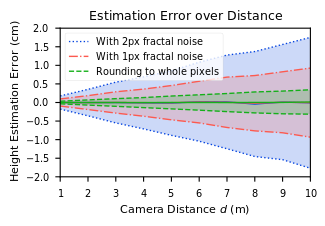

In [18]:
plot_height_estimation(distances, heights_dist_noise2px,
                       title='',
                       label=f'With 2px fractal noise',
                       xlabel='',
                       els=':')
plot_height_estimation(distances, heights_dist_noise1px,
                       title='',
                       label=f'With 1px fractal noise',
                       xlabel='',
                       els='-.')
plot_height_estimation(distances, heights_dist,
                       title='Estimation Error over Distance',
                       label='Rounding to whole pixels',
                       xlabel='Camera Distance $d$ (m)',
                       els='--')
plt.xticks(distances)
plt.yticks(np.linspace(-2, 2, 9))
plt.ylim(-2, 2)
plt.save_show_close("graphics/plot_camera_distance.pgf.tex", bbox_inches='tight')

In [19]:
#min_amplitude = 0.0
#max_amplitude = 16.0
#amplitudes = np.linspace(min_amplitude, max_amplitude, 17)
amplitudes = all_parameter_values[all_parameter_values >= 0]
np.random.seed(seed+10)
heights_noise_fractal = np.asarray([
    [eval_jump(t, z, noise=fractal_noise, noise_args={'amplitude':a}) for t, z in dataset]
    for a in amplitudes
])

heights_noise_uniform = np.asarray([
    [eval_jump(t, z, noise=uniform_noise, noise_args={'amplitude':a}) for t, z in dataset]
    for a in amplitudes
])

heights_noise_normal95 = np.asarray([
    [eval_jump(t, z, noise=normal95_noise, noise_args={'amplitude':a}) for t, z in dataset]
    for a in amplitudes
])

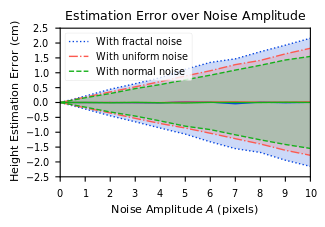

In [20]:
plot_height_estimation(amplitudes, heights_noise_fractal,
                       title='',
                       label='With fractal noise',
                       xlabel='',
                       els=':')

plot_height_estimation(amplitudes, heights_noise_uniform,
                       title='',
                       label='With uniform noise',
                       xlabel='',
                       els='-.')

plot_height_estimation(amplitudes, heights_noise_normal95,
                       title='Estimation Error over Noise Amplitude',
                       label='With normal noise',
                       xlabel='Noise Amplitude $A$ (pixels)',
                       els='--')
plt.xticks(amplitudes)
plt.yticks(np.linspace(-2.5, 2.5, 11))
plt.ylim(-2.5, 2.5)
#plt.yticks(np.linspace(-2, 2, 9))
#plt.ylim(-2, 2)
plt.save_show_close("graphics/plot_noise_amplitude.pgf.tex", bbox_inches='tight')



## Evaluate estimation error over camera angle

In [21]:
# min_angle = -20
# max_angle = 20
# angles = np.linspace(min_angle, max_angle, 11)
angles = all_parameter_values

heights_angle = np.asarray([
    [eval_jump(t, z, cam_angle=a) for t, z in dataset]
    for a in angles
])
heights_angle_1m = np.asarray([
    [eval_jump(t, z, cam_angle=a, distance=1) for t, z in dataset]
    for a in angles
])
# heights_angle_noise = np.asarray([
#     [eval_jump(t, z, cam_angle=a, noise=fractal_noise) for t, z in dataset]
#     for a in angles
# ])


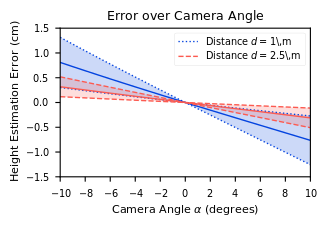

In [22]:
# plot_height_estimation(angles, heights_angle_noise,
#                            title='Error over camera angle',
#                            label=f'With {default_noise_amplitude} px fractal noise',
#                            xlabel='Camera angle (degrees)')
plot_height_estimation(angles, heights_angle_1m,
                       title='',
                       label=f'Distance $d=1$\\,m',
                       xlabel='',
                       els=':')
plot_height_estimation(angles, heights_angle,
                       title='Error over Camera Angle',
                       label=f'Distance $d={default_subject_distance}$\\,m',
                       xlabel=r'Camera Angle $\alpha$ (degrees)',
                       els='--')
plt.xticks(range(int(min(angles)), int(max(angles)) + 1, 2))
plt.yticks(np.linspace(-1.5, 1.5, 7))
plt.ylim(-1.5, 1.5)
plt.save_show_close("graphics/plot_camera_angle.pgf.tex", bbox_inches='tight')


## Evaluate estimation error over jump distance movements

In [23]:
distmoves = all_parameter_values

heights_distmove = np.asarray([
    [eval_jump(t, z, distance_movement=d/100) for t, z in dataset]
    for d in distmoves
])
heights_distmove_1m = np.asarray([
    [eval_jump(t, z, distance_movement=d/100, distance=1) for t, z in dataset]
    for d in distmoves
])
# heights_distmove_noise = np.asarray([
#     [eval_jump(t, z, distance_movement=d/100, noise=fractal_noise) for t, z in dataset]
#     for d in distmoves
# ])


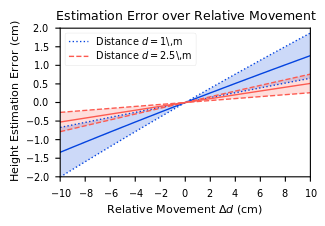

In [24]:
# plot_height_estimation(distmoves, heights_distmove_noise,
#                            title='Error over Camera Distance movement mistakes with fractal_noise',
#                            label=f'With {default_noise_amplitude} px fractal noise',
#                            xlabel='Camera Distance Movement (cm)')

plot_height_estimation(distmoves, heights_distmove_1m,
                       title='',
                       label=f'Distance $d=1$\\,m',
                       xlabel='',
                       els=':')

plot_height_estimation(distmoves, heights_distmove,
                       title='Estimation Error over Relative Movement',
                       label=f'Distance $d={default_subject_distance}$\\,m',
                       xlabel=r'Relative Movement $\Delta d$ (cm)',
                       els='--')

plt.xticks(range(int(min(distmoves)), int(max(distmoves)) + 1, 2))
plt.yticks(np.linspace(-2, 2, 9))
plt.ylim(-2, 2)
plt.save_show_close("graphics/plot_distance_movement.pgf.tex", bbox_inches='tight')


## Test Lens Distortion

Create a grid in image coordinates. This will be used to visualize lens distortion in the following test.

[[1080.         1920.        ]
 [1069.30693069 1920.        ]
 [1058.61386139 1920.        ]
 ...
 [   0.         1894.65346535]
 [   0.         1907.32673267]
 [   0.         1920.        ]]


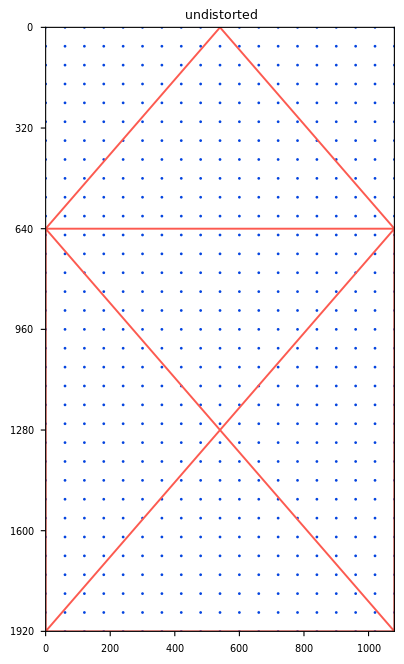

In [25]:
grid = np.array([ (x,y) for y in range(0, 1921, 60) for x in range(0, 1081, 60) ])
grid = grid + 0.0001 # Add infinitesimal offset to avoid division by zero for center point in lens_distortion.py:169
#print(grid)

house_2d = -house_points_3d[:,:2]
house_2d = house_2d - [min(house_2d[:,0]), min(house_2d[:,1])]
house_2d = house_2d / [max(house_2d[:,0]), max(house_2d[:,1])] * [1080,1920]
house_t = np.linspace(0, 1, len(house_2d))
house_interp = np.linspace(0, 1, len(house_2d) + 100*(len(house_2d)-1))
house_x, house_y = house_2d[:,0], house_2d[:,1]
house_x = np.interp(house_interp, house_t, house_x)
house_y = np.interp(house_interp, house_t, house_y)
house_2d = np.column_stack([house_x, house_y])

print(house_2d)

plt.figure(figsize=(9/2,16/2))
plt.ylim(1920,0)
plt.yticks(range(0, 1921, 320))
plt.xlim(0,1080)
plt.title('undistorted')
plt.plot(grid[:,0], grid[:,1], marker='.', linewidth=0, markersize=4)
plt.plot(house_x, house_y, marker='x')
plt.show_close()


## Visualize the impact of lens distortion

First, some helper functions to apply distortion to points in a world or an image coordinate system.

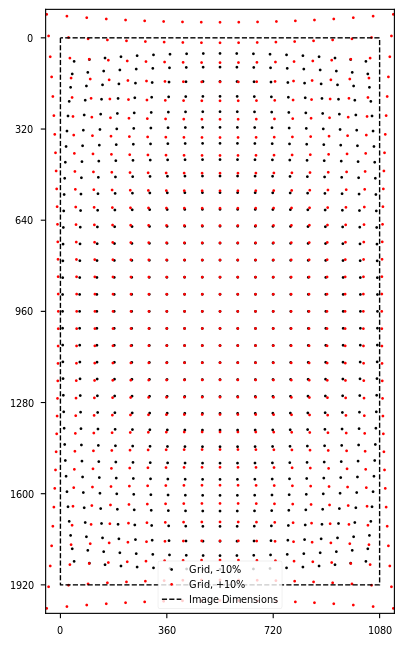

In [26]:
def distort_world_points(points, delta):
    cam = create_camera(ct.BrownLensDistortion(k1=delta, k2=delta, k3=delta), cam_angle=-90)
    return cam.imageFromSpace(points) 

def distort_screen_points(points, delta):
    cam = create_camera(cam_angle=-90)
    world_points=cam.spaceFromImage(points)
    cam = create_camera(ct.BrownLensDistortion(k1=delta, k2=delta, k3=delta), cam_angle=-90)
    return cam.imageFromSpace(world_points)

image_frame = [
    [0, 0, 1080, 1080, 0],
    [0, 1920, 1920, 0, 0],
]

plt.figure(figsize=(4.5,8))
grid_distort_min = distort_screen_points(grid, -10/100)
grid_distort_max = distort_screen_points(grid, +10/100)
plt.plot(*np.hsplit(grid_distort_min, 2), color='black', marker='.', linewidth=0, markersize=4, label=f'Grid, -10%')
plt.plot(*np.hsplit(grid_distort_max, 2), color='red', marker='.', linewidth=0, markersize=4, label=f'Grid, +10%')
plt.plot(*image_frame, color='black', lw=1, ls='--', label='Image Dimensions')
plt.ylim(100+1920,0-100)
plt.yticks(range(0, 1921, 320))
plt.xlim(-50,1080+50)
plt.xticks(range(0, 1081, 360))
plt.legend()
plt.show_close()


Max displacement of grid points for delta=-10%: 94.7 px
Max displacement of grid points for delta=+10%: 94.7 px


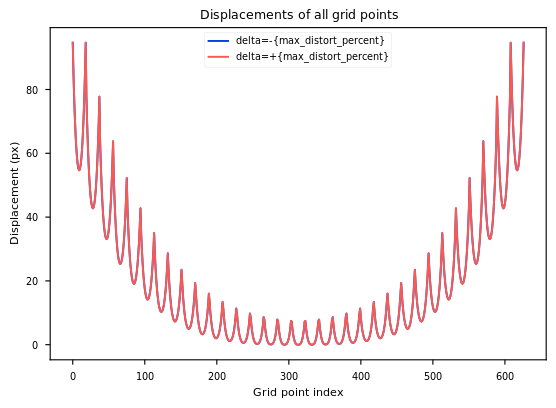

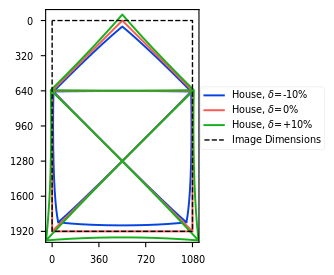

In [27]:

distortions = all_parameter_values

max_distort_percent = max(distortions)
max_distort = max_distort_percent / 100

house_distort_min = distort_screen_points(house_2d, -max_distort)
house_distort_max = distort_screen_points(house_2d, max_distort)
grid_distort_min = distort_screen_points(grid, -max_distort)
grid_distort_max = distort_screen_points(grid, max_distort)

grid_diff_min = grid - grid_distort_min
grid_displace_min = np.sqrt(grid_diff_min[:,0] ** 2 + grid_diff_min[:,1] ** 2)
grid_diff_max = grid - grid_distort_max
grid_displace_max = np.sqrt(grid_diff_max[:,0] ** 2 + grid_diff_max[:,1] ** 2)

print(f'Max displacement of grid points for delta=-{max_distort_percent}%: {max(grid_displace_min):.1f} px')
print(f'Max displacement of grid points for delta=+{max_distort_percent}%: {max(grid_displace_max):.1f} px')

plt.figure()
plt.title('Displacements of all grid points')
plt.xlabel('Grid point index')
plt.ylabel('Displacement (px)')
plt.plot(grid_displace_min, label='delta=-{max_distort_percent}')
plt.plot(grid_displace_max, label='delta=+{max_distort_percent}')
plt.legend()
plt.show_close()

plt.figure(figsize=(4.5,8), constrained_layout=True)
plt.gcf().set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
#plt.gcf().suptitle(f'Comparison of image distortion parameters')
plt.ylim(100+1920,0-100)
plt.yticks(range(0, 1921, 320))
plt.xlim(-50,1080+50)
plt.xticks(range(0, 1081, 360))
#plt.title(f'Comparison of image distortion parameters')
plt.plot(*np.hsplit(house_distort_min, 2), label=f'House, $\delta$=-{max_distort_percent}%')
plt.plot(*np.hsplit(house_2d, 2), label='House, $\delta$=0%')
plt.plot(*np.hsplit(house_distort_max, 2), label=f'House, $\delta$=+{max_distort_percent}%')
#plt.plot(*np.hsplit(grid_distort_min, 2), color='black', marker='.', linewidth=0, markersize=4, label=f'Grid, $\delta$=-{max_distort_percent}%')
plt.plot(*image_frame, color='black', lw=1, ls='--', label='Image Dimensions')
plt.legend(loc=(1.01,0.4))

plt.save_show_close("graphics/plot_lens_distortion_demo.pgf.tex", width_cm=8.2, height_cm=6.7, bbox_inches='tight', pad_inches=0)



## Evaluate estimation error over lens distortion

In [28]:
distortions = all_parameter_values

heights_distortion = np.asarray([
    [eval_jump(t, z, distortion=d/100) for t, z in dataset]
    for d in distortions
])
heights_distortion_1m = np.asarray([
    [eval_jump(t, z, distortion=d/100, distance=1) for t, z in dataset]
    for d in distortions
])
# heights_distortion_noise = np.asarray([
#     [eval_jump(t, z, distortion=d, noise=fractal_noise) for t, z in dataset]
#     for d in distortions
# ])


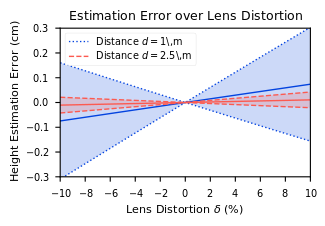

In [29]:
# plot_height_estimation(all_parameter_values, heights_distortion_noise,
#                            title='Estimation Error over lens distortion',
#                            label=f'With {default_noise_amplitude} px fractal noise',
#                            xlabel='Lens Distortion (%)')
plot_height_estimation(distortions, heights_distortion_1m,
                       title='',
                       label=f'Distance $d=1$\\,m',
                       xlabel='',
                       els=':')

plot_height_estimation(distortions, heights_distortion,
                       title='Estimation Error over Lens Distortion',
                       label=f'Distance $d={default_subject_distance}$\\,m',
                       xlabel='Lens Distortion $\delta$ (%)',
                       els='--')

plt.xticks(range(int(min(distortions)), int(max(distortions)) + 1, 2))
plt.yticks(np.linspace(-0.3, 0.3, 7))
plt.ylim(-0.3, 0.3)
plt.save_show_close("graphics/plot_lens_distortion.pgf.tex", bbox_inches='tight')


## Evaluate estimation error over combination of all parameters

In [30]:
values = all_parameter_values[all_parameter_values >= 0]

heights_all_parameters = np.asarray([
    [eval_jump(t, z,
               distance=default_subject_distance,
               distortion=v/100,
               noise=fractal_noise, noise_args={'amplitude':v},
               cam_angle=-v,
               distance_movement=v/100)
         for t, z in dataset
    ]
    for v in values
])
heights_all_parameters_1m = np.asarray([
    [eval_jump(t, z,
               distance=1,
               distortion=v/100,
               noise=fractal_noise, noise_args={'amplitude':v},
               cam_angle=-v,
               distance_movement=v/100)
         for t, z in dataset
    ]
    for v in values
])

# heights_distortion_noise = np.asarray([
#     [eval_jump(t, z, distortion=d, noise=fractal_noise) for t, z in dataset]
#     for d in distortions
# ])


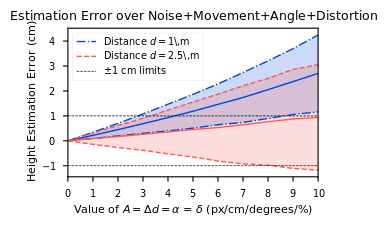

In [31]:
plot_height_estimation(values, heights_all_parameters_1m,
                       title='',
                       label=f'Distance $d=1$\\,m',
                       xlabel='',
                       els='-.')

plot_height_estimation(values, heights_all_parameters,
                       title='Estimation Error over Noise+Movement+Angle+Distortion',
                       label=f'Distance $d={default_subject_distance}$\\,m',
                       xlabel=r'Value of $A = \Delta d = \alpha$ = $\delta$ (px/cm/degrees/%)',
                       els='--')

plt.plot([0,10],[1,1], color='black', ls='--', lw=0.5, label='$\pm 1$ cm limits')
plt.axhline(-1, color='black', ls='--', lw=0.5)
plt.legend()
plt.xticks(values)
plt.save_show_close("graphics/plot_all_parameters.pgf.tex", bbox_inches='tight')


# Calculate some metrics for the paper text

In [32]:
np.random.seed(seed+10)
heights_default_dist_noise2px_rounded = [
    eval_jump(t, z, noise=fractal_noise, noise_args={'amplitude':2}, rounded=True) for t, z in dataset
]
np.random.seed(seed+10)
heights_default_dist_noise2px = [eval_jump(t, z, noise=fractal_noise, noise_args={'amplitude':2}) for t, z in dataset]
np.random.seed(seed+10)
heights_default_dist_noise8px = [eval_jump(t, z, noise=fractal_noise, noise_args={'amplitude':8}) for t, z in dataset]
heights_default_dist_rounded = [eval_jump(t, z, rounded=True) for t, z in dataset]

In [33]:
def loa_1d(jump_height_values, means=False):
    errors = np.asarray(jump_height_values) - dataset_jump_heights
    loa = 1.96 * np.std(errors)
    if means:
        return loa, np.mean(errors)
    return loa

def loa_2d(jump_height_values, means=False):
    errors = np.asarray(jump_height_values) - dataset_jump_heights
    loas = 1.96 * np.std(errors, axis=1)
    if means:
        return loas, np.mean(errors, axis=1)
    return loas

def loa_2d_dict(parameter_values, jump_height_values, means=False):
    loa, mean = loa_2d(jump_height_values, means=True)
    loa_dict = dict(zip(parameter_values, loa))
    if means:
        return loa_dict, dict(zip(parameter_values, mean))
    return loa_dict

def slope(values_dict, low_param, high_param):
    return (values_dict[high_param] - loa_noise[low_param]) / (high_param - low_param)

In [34]:
# display(Markdown(f'At the chosen default camera distance of {default_subject_distance} m, ' +
#                  f'with a fractal noise amplitude of 2 px, the 95% LOA of the jump height error ' +
#                  f'is +/-{scale("cm",loa_1d(heights_default_dist_noise2px_rounded)):.2f} cm with rounding and ' +
#                  f'+/-{scale("cm",loa_1d(heights_default_dist_noise2px)):.2f} cm without rounding.'))

loa_noise = loa_2d_dict(amplitudes, heights_noise_fractal)

display(Markdown('### Results for $A$'))
display(Markdown(f'At the chosen default camera distance of {default_subject_distance} m, ' +
                 f'the 95% LOA of the jump height error increases by ' +
                 f'{scale("cm", slope(loa_noise, 0, 10)):.2f} cm for every px of noise amplitude.'))

loa_distmove, means_distmove = loa_2d_dict(distmoves, heights_distmove, means=True)
loa_distmove_1m, means_distmove_1m = loa_2d_dict(distmoves, heights_distmove_1m, means=True)

display(Markdown('### Results for $\\Delta d$'))
display(Markdown(f'At the chosen default camera distance of {default_subject_distance} m, ' +
                 f'the systematic jump height error increases by ' +
                 f'{10*scale("cm", slope(means_distmove, 0, 10)):.2f}cm for every 10cm increase in $\\Delta d$ ' +
                 f'and the 95% LOA increases by {10*scale("cm", slope(loa_distmove, 0, 10)):.2f}cm.'))
display(Markdown(f'Placing the camera closer to the subject at $d=1$m increases these ' +
                 f'values significantly to ' +
                 f'{10*scale("cm", slope(means_distmove_1m, 0, 10)):.2f} $\\pm$ ' +
                 f'{10*scale("cm", slope(loa_distmove_1m, 0, 10)):.2f}cm per 10cm of $\\Delta d$.'))

loa_angle, means_angle = loa_2d_dict(angles, heights_angle, means=True)
loa_angle_1m, means_angle_1m = loa_2d_dict(angles, heights_angle_1m, means=True)

display(Markdown('### Results for $\\alpha$'))
display(Markdown(f'At the chosen default camera distance of {default_subject_distance} m, ' +
                 f'the systematic jump height error increases by ' +
                 f'{10*scale("cm", slope(means_angle, 0, 10)):.2f}cm for every 10 degrees increase in $\\alpha$ ' +
                 f'and the 95% LOA increases by {10*scale("cm", slope(loa_angle, 0, 10)):.2f}cm.'))
display(Markdown(f'Placing the camera closer to the subject at $d=1$m increases these ' +
                 f'values significantly to ' +
                 f'{10*scale("cm", slope(means_angle_1m, 0, 10)):.2f} $\\pm$ ' +
                 f'{10*scale("cm", slope(loa_angle_1m, 0, 10)):.2f}cm per 10 degrees of $\\alpha$.'))

loa_distortion, means_distortion = loa_2d_dict(distortions, heights_distortion, means=True)
loa_distortion_1m, means_distortion_1m = loa_2d_dict(distortions, heights_distortion_1m, means=True)

display(Markdown('### Results for $\\delta$'))
display(Markdown(f'Lens distortion has only a very small impact at $d={default_subject_distance}$m with an error of '+
                 f'{10*scale("cm", slope(means_distortion, 0, 10)):.2f} $\\pm$ ' +
                 f'{10*scale("cm", slope(loa_distortion, 0, 10)):.2f}cm per 10 percent ' +
                 f'increase of $\\delta$ in the examined value range, ' +
                 f'and a larger error of ' +
                 f'{10*scale("cm", slope(means_distortion_1m, 0, 10)):.2f} $\\pm$ ' +
                 f'{10*scale("cm", slope(loa_distortion_1m, 0, 10)):.2f}cm per 10 percent of $\\delta$ ' +
                 f'at $d=1$m.'))



### Results for $A$

At the chosen default camera distance of 2.5 m, the 95% LOA of the jump height error increases by 0.22 cm for every px of noise amplitude.

### Results for $\Delta d$

At the chosen default camera distance of 2.5 m, the systematic jump height error increases by 0.51cm for every 10cm increase in $\Delta d$ and the 95% LOA increases by 0.25cm.

Placing the camera closer to the subject at $d=1$m increases these values significantly to 1.26 $\pm$ 0.61cm per 10cm of $\Delta d$.

### Results for $\alpha$

At the chosen default camera distance of 2.5 m, the systematic jump height error increases by -0.31cm for every 10 degrees increase in $\alpha$ and the 95% LOA increases by 0.20cm.

Placing the camera closer to the subject at $d=1$m increases these values significantly to -0.76 $\pm$ 0.49cm per 10 degrees of $\alpha$.

### Results for $\delta$

Lens distortion has only a very small impact at $d=2.5$m with an error of 0.01 $\pm$ 0.03cm per 10 percent increase of $\delta$ in the examined value range, and a larger error of 0.07 $\pm$ 0.23cm per 10 percent of $\delta$ at $d=1$m.

## Compute ICC values for "All Parameters" case

According to https://stats.stackexchange.com/questions/177091/inter-intra-class-correlation-coefficient-or-intra-inter-concordance-coeff/

(11, 2000)


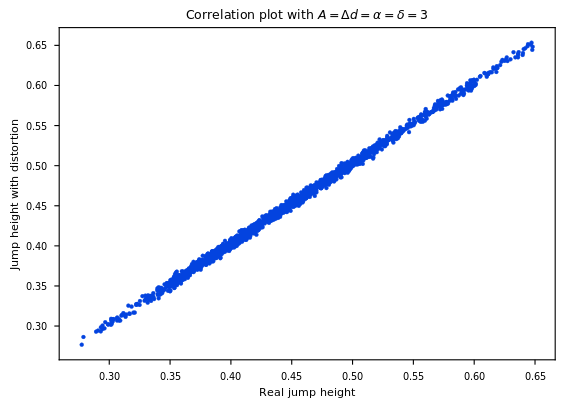

ICC(3,1) for $A=\Delta d=\alpha=\delta=3$ is:

Description    Single fixed raters
ICC                       0.998915
F                      1841.999572
df1                           1999
df2                           1999
pval                           0.0
CI95%                   [1.0, 1.0]
Name: ICC3, dtype: object

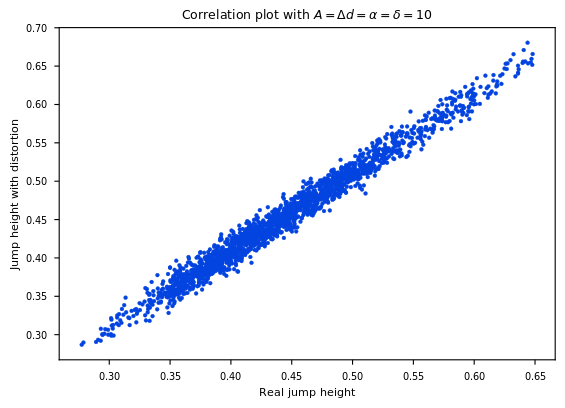

ICC(3,1) for $A=\Delta d=\alpha=\delta=10$ is:

Description    Single fixed raters
ICC                       0.988458
F                       172.286417
df1                           1999
df2                           1999
pval                           0.0
CI95%                 [0.99, 0.99]
Name: ICC3, dtype: object

In [35]:
print(heights_all_parameters.shape)

import pandas as pd
import pingouin as pg

def calculate_icc(parameter_index):
    parameter_value = values[parameter_index]
    plt.scatter(dataset_jump_heights, heights_all_parameters[parameter_index,:], marker='.')
    plt.title(f'Correlation plot with $A=\\Delta d=\\alpha=\\delta={parameter_value}$')
    plt.xlabel('Real jump height')
    plt.ylabel(r'Jump height with distortion')
    plt.show_close()

    df = pd.DataFrame({'exam': list(range(dataset_size)) * 2,
                       'method': ['A'] * dataset_size + ['B'] * dataset_size,
                       'rating': list(dataset_jump_heights) + list(heights_all_parameters[parameter_index,:])})
    #display(df)

    icc = pg.intraclass_corr(data=df, targets='exam', raters='method', ratings='rating')
    icc = icc.set_index('Type')
    
    display(Markdown(f'ICC(3,1) for $A=\\Delta d=\\alpha=\\delta={parameter_value}$ is:'))
    display(icc.loc['ICC3'])
    

calculate_icc(3)
calculate_icc(10)